In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import os
import shutil

import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [14]:
train_folder_name = '../Trabalho-CNN/archive/working/data/natural_images/'
img_size = (128,128)
classes = sorted(os.listdir(train_folder_name))

print(classes)

['aviao', 'cachorro', 'carro', 'flor', 'fruta', 'gato', 'moto', 'pessoa']


In [15]:
torch.cuda.empty_cache()

In [16]:
# funçao para  
def load_dataset(data_path):

    transformations = transforms.Compose([transforms.RandomHorizontalFlip(0.5), transforms.RandomVerticalFlip(0.3), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
    full_dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transformations)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, num_workers=0, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, num_workers=0, shuffle=False) 
    
    return train_loader, test_loader

train_folder = '../Trabalho-CNN/archive/working/data/natural_images/'
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size

In [17]:
class Net(nn.Module):
    
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.2)
        self.fc = nn.Linear(in_features=16 * 16 * 24, out_features=num_classes)

    def forward(self, x):

        x = F.relu(self.pool(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x)))  
        x = F.relu(self.pool(self.conv3(x)))  
        x = F.dropout(self.drop(x), training=self.training)
        x = x.view(-1, 16 * 16 * 24)
        x = self.fc(x)

        return torch.log_softmax(x, dim=1)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=6144, out_features=8, bias=True)
)


In [18]:
#model = (torch.load("../Trabalho-CNN/modelo/modelo.pth"))

In [19]:
def train(model, device, train_loader, optimizer, epoch):

    model.train()
    train_loss = 0
    print("Epoch:", epoch)

    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Avg Loss: {:.6f}'.format(avg_loss))
    
    return avg_loss

In [20]:
def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():

        batch_count = 0

        for data, target in test_loader:

            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    avg_loss = test_loss / batch_count
    print('Validation set: Avg Loss: {:.6f}, Acc: {}/{} ({:.0f}%)\n'.format(avg_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

    return avg_loss

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_criteria = nn.CrossEntropyLoss()
epoch_nums = []
training_loss = []
validation_loss = []
epochs = 10
print('Training on', device)

for epoch in range(1, epochs + 1):
        
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set: Avg Loss: 1.013543
Validation set: Avg Loss: 0.694075, Acc: 1605/2070 (78%)

Epoch: 2
Training set: Avg Loss: 0.567894
Validation set: Avg Loss: 0.433037, Acc: 1721/2070 (83%)

Epoch: 3
Training set: Avg Loss: 0.556770
Validation set: Avg Loss: 0.684275, Acc: 1575/2070 (76%)

Epoch: 4
Training set: Avg Loss: 0.640601
Validation set: Avg Loss: 0.450768, Acc: 1720/2070 (83%)

Epoch: 5
Training set: Avg Loss: 0.541264
Validation set: Avg Loss: 0.402446, Acc: 1765/2070 (85%)

Epoch: 6
Training set: Avg Loss: 0.397744
Validation set: Avg Loss: 0.321572, Acc: 1809/2070 (87%)

Epoch: 7
Training set: Avg Loss: 0.405243
Validation set: Avg Loss: 0.296376, Acc: 1812/2070 (88%)

Epoch: 8
Training set: Avg Loss: 0.355623
Validation set: Avg Loss: 0.308268, Acc: 1809/2070 (87%)

Epoch: 9
Training set: Avg Loss: 0.356416
Validation set: Avg Loss: 0.284857, Acc: 1838/2070 (89%)

Epoch: 10
Training set: Avg Loss: 0.313729
Validation set: Avg Loss: 0.280276, Acc:

In [22]:
#torch.save(model, "../Trabalho-CNN/modelo/modelo.pth")

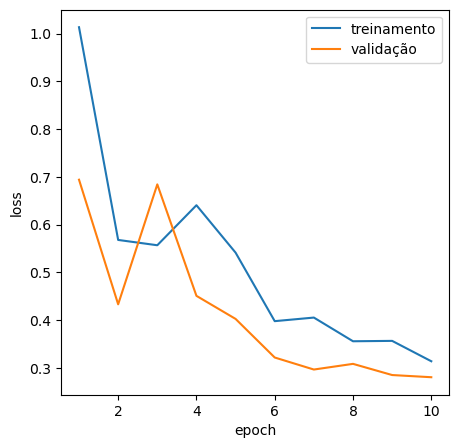

In [23]:
plt.figure(figsize=(5,5))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['treinamento', 'validação'], loc='upper right')
plt.show()

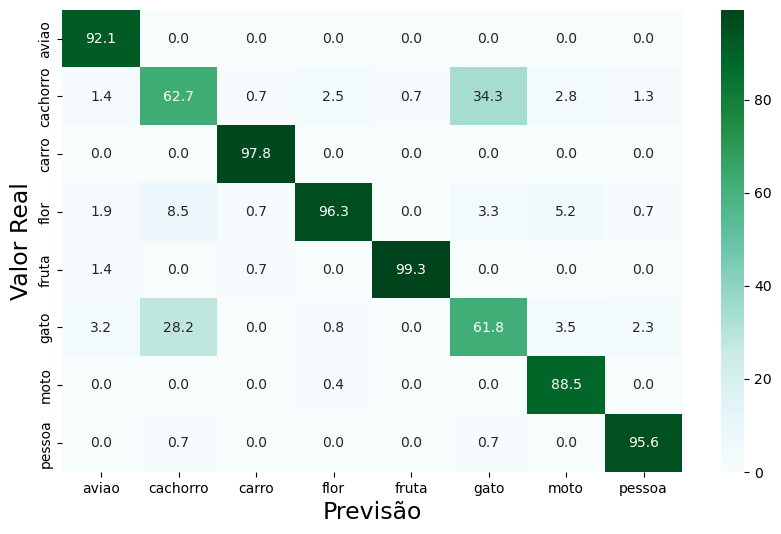

In [24]:
truelabels = []
predictions = []
model.eval()

for data, target in test_loader:

    data = data.to(device)

    for label in target.data.numpy():

        truelabels.append(label)

    for prediction in model(data).cpu().data.numpy().argmax(1):

        predictions.append(prediction) 

cm = confusion_matrix(truelabels, predictions)
cm = (cm.astype('float') / cm.sum(axis=0)) * 100
tick_marks = np.arange(len(classes))
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize=(10,6))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.BuGn, fmt='.1f')
plt.xlabel("Previsão", fontsize = 17)
plt.ylabel("Valor Real", fontsize = 17)
plt.show()